#### Gaussian process regressor with Matern kernel

In [29]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from tpot.export_utils import set_param_recursive
import xarray as xr
from SALib.sample import saltelli
from SALib.analyze import sobol
import joblib
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [10]:
# emulator setup
path = '/nfs/b0004/Users/earlacoa/paper_aia_china/emulator/'

with open(path + 'dict_train.pickle', 'rb') as ds:
    dict_train = pickle.load(ds)
    
with open(path + 'dict_test.pickle', 'rb') as ds:
    dict_test = pickle.load(ds)
    
df_train = pd.concat(dict_train, ignore_index=True)
df_test = pd.concat(dict_test, ignore_index=True)

inputs_train = pd.read_csv('/nfs/see-fs-02_users/earlacoa/emulator/latin_hypercube_inputs_train.csv')
inputs_test = pd.read_csv('/nfs/see-fs-02_users/earlacoa/emulator/latin_hypercube_inputs_test.csv')
X_train, X_test = inputs_train.values, inputs_test.values

lats = df_train[['lat', 'lon']].drop_duplicates()['lat'].values
lons = df_train[['lat', 'lon']].drop_duplicates()['lon'].values

output = 'PM2_5_DRY'

df_eval_summary = pd.DataFrame(columns=['output', 'rmse_cv', 'r2_cv', 'rmse_test', 'r2_test'])

In [4]:
# sensitivity analysis setup
sims = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
sens_inds_S1_ST = ['S1', 'S1_conf', 'ST', 'ST_conf']
ds_sens_ind = xr.Dataset({})

empty_values = np.empty((580, 1440))
empty_values[:] = np.nan
empty_da = xr.DataArray(
    empty_values, 
    dims=('lat', 'lon'), 
    coords={'lat': np.arange(-60, 85, 0.25), 'lon': np.arange(-180, 180, 0.25)}
)

for sim in sims:
    for sens_ind in sens_inds_S1_ST:
        ds_sens_ind.update({sens_ind + '_' + sim: empty_da})
        
sims_S2 = ['RES_IND', 'RES_TRA', 'RES_AGR', 'RES_ENE', 'IND_TRA', 'IND_AGR', 'IND_ENE', 'TRA_AGR', 'TRA_ENE', 'AGR_ENE']
sims_S2_indexes = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
sens_inds_S2 = ['S2', 'S2_conf']

for sim in sims_S2:
    for sens_ind in sens_inds_S2:
        ds_sens_ind.update({sens_ind + '_' + sim: empty_da})

sens_inputs = {
    'num_vars': 5,
    'names': sims,
    'bounds': [[0.0, 1.5],
               [0.0, 1.5],
               [0.0, 1.5],
               [0.0, 1.5],
               [0.0, 1.5]]
}

sens_param_values = saltelli.sample(sens_inputs, 1000)

In [12]:
def output_values(gridcell, df_train, df_test, output):
    lat, lon = gridcell
    
    df_train_gridcell = df_train.loc[df_train.lat == lat].loc[df_train.lon == lon]
    df_test_gridcell = df_test.loc[df_test.lat == lat].loc[df_test.lon == lon]
    
    y_train, y_test = df_train_gridcell[output].values, df_test_gridcell[output].values
    
    return lat, lon, y_train, y_test

def create_emulator():
    emulator = make_pipeline(
        PowerTransformer(),
        GaussianProcessRegressor(
            kernel=Matern(length_scale=3.4000000000000004, nu=2.5), 
            n_restarts_optimizer=240, 
            normalize_y=False)
    )
    set_param_recursive(emulator.steps, 'random_state', 123)
    
    return emulator


def emulator_cv(emulator, X_train, y_train, y_test):
    cv = cross_validate(emulator, X_train, y_train, cv=10, scoring={'r2': 'r2', 'rmse': 'neg_mean_squared_error'})
    
    return cv


def emulator_fit_save(emulator, X_train, y_train, path, output, lat, lon):
    emulator.fit(X_train, y_train)
        
    #joblib.dump(emulator, path + 'gaussian_powertransformer/' + output + '/emulator_' + output + '_' + str(lat) + '_' + str(lon) + '.joblib')
    
    return emulator
    
    
def sensitivity_analysis(sens_inputs, sens_predictions):
    sens_ind_dict = sobol.analyze(sens_inputs, sens_predictions)
    
    return sens_ind_dict

In [6]:
def emulator_with_sensitivity(gridcell):
    lat, lon, y_train, y_test = output_values(gridcell, df_train, df_test, output)
    
    emulator = create_emulator()
    
    cv = emulator_cv(emulator, X_train, y_train, y_test)
    r2_cv = cv['test_r2']
    rmse_cv = np.sqrt(np.abs(cv['test_rmse']))
    
    emulator = emulator_fit_save(emulator, X_train, y_train, path, output, lat, lon)
    
    y_pred = emulator.predict(X_test)
    
    sens_predictions = emulator.predict(sens_param_values)
    sens_ind_dict = sensitivity_analysis(sens_inputs, sens_predictions)

    return lat, lon, output, y_test, y_pred, rmse_cv, r2_cv, sens_ind_dict

In [13]:
gridcells = df_train[['lat', 'lon']].drop_duplicates().values.tolist()[0:1]
results = []

for gridcell in gridcells:
    results.append(emulator_with_sensitivity(gridcell))

In [14]:
results

[(18.25,
  109.0,
  'PM2_5_DRY',
  array([24.37751456, 18.77551019, 34.81053061, 29.2836425 , 27.59900245]),
  array([24.29294874, 18.40820184, 34.94204844, 29.04515439, 27.71700876]),
  array([0.29594367, 0.59118992, 0.3488771 , 0.36324489, 0.41527618,
         1.4526067 , 0.34952694, 0.24650646, 0.21965723, 0.42626319]),
  array([0.99672531, 0.94907674, 0.99121491, 0.99223964, 0.98483207,
         0.95896013, 0.99467178, 0.99773037, 0.99329   , 0.95620107]),
  {'S1': array([0.4820289 , 0.29087837, 0.02797659, 0.19166224, 0.0034219 ]),
   'S1_conf': array([0.04530472, 0.05053894, 0.01403335, 0.03483826, 0.00565188]),
   'ST': array([0.48354758, 0.30332518, 0.03177901, 0.19892916, 0.0046384 ]),
   'ST_conf': array([0.035079  , 0.02649052, 0.00406518, 0.01841933, 0.00060121]),
   'S2': array([[        nan,  0.00235946,  0.00359526,  0.00658734,  0.00430539],
          [        nan,         nan,  0.00555608,  0.01090118,  0.00640769],
          [        nan,         nan,         nan,  0.

In [26]:
y_test = np.array([result[3] for result in results]).ravel()
y_pred = np.array([result[4] for result in results]).ravel()
rmse_cv = np.round(np.mean(np.array([result[5] for result in results])), decimals=4)
r2_cv = np.round(np.mean(np.array([result[6] for result in results])), decimals=4)
rmse_test = np.round(np.sqrt(np.abs(mean_squared_error(y_test, y_pred))), decimals=4)
r2_test = np.round(r2_score(y_test, y_pred), decimals=4)

df_eval_summary = df_eval_summary.append([{
        'output': output,
        'y_test': y_test,
        'y_pred': y_pred,
        'rmse_cv': rmse_cv, 
        'r2_cv': r2_cv,                                             
        'rmse_test': rmse_test, 
        'r2_test': r2_test}],              
        ignore_index=True, 
        sort=False)
#df_eval_summary.to_csv(path + 'gaussian_powertransformer/' + output + '/df_eval_summary_' + output + '.csv')
#df_eval_summary

In [16]:
lats = np.array([result[0] for result in results]).ravel()
lons = np.array([result[1] for result in results]).ravel()
sensitivities = [result[7] for result in results]

for output in outputs:
    for index, sens in enumerate(sensitivities):
        lat = lats[index]
        lon = lons[index]

        for sim_index, sim in enumerate(sims):
            for sens_ind_index, sens_ind in enumerate(sens_inds_S1_ST):
                ds_sens_ind[sens_ind + '_' + sim] = xr.where(
                    (ds_sens_ind.coords['lat'] == lat) & (ds_sens_ind.coords['lon'] == lon),
                    sens[sens_ind][sim_index],
                    ds_sens_ind[sens_ind + '_' + sim]
                )

        for sim_index, sim in enumerate(sims_S2):
            for sens_ind_index, sens_ind in enumerate(sens_inds_S2):
                ds_sens_ind[sens_ind + '_' + sim] = xr.where(
                    (ds_sens_ind.coords['lat'] == lat) & (ds_sens_ind.coords['lon'] == lon),
                    sens[sens_ind][sims_S2_indexes[sim_index][0], sims_S2_indexes[sim_index][1]],
                    ds_sens_ind[sens_ind + '_' + sim]
                )
        
    #ds_sens_ind.to_netcdf(path + 'gaussian_powertransformer/' + output + '/ds_sens_ind_' + output + '.nc')

In [23]:
def make_plot(index, output, label, y_test, y_pred, r2_cv, rmse_cv, r2_test, rmse_test):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    limit = np.nanmax(y_pred)
    plt.xlim([0, limit])
    plt.ylim([0, limit])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Simulator, ' + label, fontsize=14)
    plt.ylabel('Emulator, ' + label, fontsize=14)
    plt.scatter(np.vstack(y_test), np.vstack(y_pred))
    x = np.arange(2 * np.ceil(limit))
    plt.plot(x, x, '', color='grey', ls='--')
    plt.plot(x, 0.5 * x, '', color='grey', ls='--')
    plt.plot(x, 2 * x, '', color='grey', ls='--')
    text = "R$^2$ CV = " + str(r2_cv) + \
           "\nRMSE CV = " + str(rmse_cv) + \
           "\nR$^2$ test = " + str(r2_test) + \
           "\nRMSE test = " + str(rmse_test)
    at = matplotlib.offsetbox.AnchoredText(text, prop=dict(size=11), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

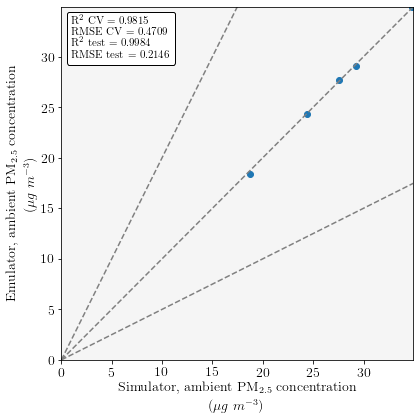

In [30]:
fig = plt.figure(1, figsize=(6, 6))
gs = gridspec.GridSpec(1, 1)

label = 'ambient PM$_{2.5}$ concentration\n(${\mu}g$ $m^{-3}$)'

make_plot(index, output, label, y_test, y_pred, r2_cv, rmse_cv, r2_test, rmse_test)

gs.tight_layout(fig, rect=[0, 0, 1.0, 1.0])
#plt.savefig('/nfs/a68/earlacoa/png/paper_aia_china_emulator/eval_jan.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/a68/earlacoa/png/paper_aia_china_emulator/eval_jan.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [ ]:
ds_sens_ind = xr.open_dataset(path + 'gaussian_powertransformer/' + output + '/ds_sens_ind_' + output + '.nc')

In [31]:
lon = ds_sens_ind['S1_RES'].lon.values
lat = ds_sens_ind['S1_RES'].lat.values
xx, yy = np.meshgrid(lon, lat)

In [ ]:
fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

sens = 'S1'
region = 'China'

label = 'ambient PM$_{2.5}$ concentrations'

sims = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
levels = {}
levels.update({'China':(0,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,100000)})
levels.update({'GBA':(0,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,100000)})
cmap_colors = {}
cmap_colors.update({'S1': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']})
cb_label = {}
cb_label.update({'S1':'First-order sensitivity indices for ' + label})
plots = [(sim, sens, region, levels[region], cmap_colors[sens], cb_label[sens], label) for sim in sims]

for index, item in enumerate(plots):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    if item[2] == 'China':
        ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
        shape_feature = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),
                                       ccrs.PlateCarree(), facecolor='none')
        ax.background_patch.set_visible(False)
        ax.outline_patch.set_visible(False)
        ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
    elif item[2] == 'GBA':
        ax.set_extent([111.3, 115.5, 21.5, 24.5], crs=ccrs.PlateCarree())
        shape_feature1 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_2.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature2 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature3 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature4 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/taiwan/gadm36_TWN_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        ax.add_feature(shape_feature1, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature2, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature3, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature4, edgecolor='black', linewidth=0.5)
    norm = matplotlib.colors.Normalize(vmin=item[3][0], vmax=item[3][-2])
    cmap = matplotlib.colors.ListedColormap(list(item[4]))
    im = ax.contourf(xx, yy, ds_sens_ind[item[1] + '_' + item[0]].values, item[3],
                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    plt.annotate(r'\textbf{' + chr(97 + index) + '}', xy=(0,1.05), xycoords='axes fraction', fontsize=14, weight='bold')
    plt.title(item[0], size=14)

fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 

plt.draw()
    
ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=levels[region][0], vmax=levels[region][-2]),                       
    cmap=im.cmap
)
sm.set_array([])  
cb = plt.colorbar(
    sm, 
    cax=ax_cbar, 
    norm=matplotlib.colors.Normalize(vmin=levels[region][0], vmax=levels[region][-2]),              
    cmap=cmap_colors[sens], 
    ticks=levels[region][0:-1]
)
cb.set_label(cb_label[sens], size=14)
cb.ax.tick_params(labelsize=14)

#plt.savefig('/nfs/a68/earlacoa/png/paper_aia_china_emulator/'+region+'_'+specie+'_compare.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/a68/earlacoa/png/paper_aia_china_emulator/'+region+'_'+specie+'_compare.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()